In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/DESI-QA/")
import find_center as fc
from spotfinder import spotfinder

plt.rcParams.update({'figure.dpi':140})


In [144]:
def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def find_spot(fitsname, fitspath,  
              expected_spot_count=1, 
              regionsname='../regions.reg', 
              verbose=False):
    """
    spotfinder handler
    input:
        fitsname:
        fitspath (str): relative or full path to the folder
        regionsname (str):
        verbose (bool):
    output: 
        centroids (dict): raw output from spotfinder

    """
    import os
    
    assert isinstance(fitsname, str)

    _ifn = f"{fitspath}/{fitsname}"
    if not (os.path.isfile(_ifn)):
        print(f"File not found \n{_ifn}")
#     if expected_spot_count != 1:
#         raise NotImplementedError("This mode wasn't tested here")
    try: 
        sf=spotfinder.SpotFinder(_ifn, expected_spot_count)
        centroids = sf.get_centroids(print_summary = verbose, 
                                     region_file=regionsname)
        if verbose: print(centroids)
    
    except Exception as err: #ignore photo if an error is raised
        print(f"{err}\nWarning: spot not found ")
        inval_number = np.nan
        return {  'peaks': [inval_number], 
                      'x': [inval_number], 
                      'y': [inval_number], 
                   'fwhm': [inval_number], 
                 'energy': [inval_number]} 
    return centroids


def collect_xy(files, picspath):
    # treating for single file
    if isinstance(files, str):
        files = [files]
    x2, y2 = [],[]
    for fullname in files:
        iname = fullname.split('/')[-1]
        _c = find_spot(iname, picspath)
        x2.append(_c['x'])
        y2.append(_c['y'])
    return x2, y2

# Fiducial calibration

TURN ON FIDUCIAL, TURN OFF POSITIONER BACKLIGHT

In [4]:
from astropy.io import fits 
fiducial_pic = "20230523-110411.fits" 
# fiducial_pic = "20230522-093243.fits" - different fiducial
fiducial_path = '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409'
dd = find_spot(fiducial_pic, 
               fiducial_path, 
               regionsname=False, 
               expected_spot_count=4)

File not found 
/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits
[Errno 2] No such file or directory: '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits'


In [5]:
img = fits.getdata(f"{fiducial_path}/{fiducial_pic}")

plt.subplot(121)
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
plt.gca().invert_yaxis()
plt.subplot(122)
plt.gca().invert_yaxis()
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
for pt, (i,j) in enumerate(zip(dd['x'], dd['y'])):
    plt.annotate(pt, xy=(i-5,j+8), xycoords='data')
plt.ylim([800, 950])
plt.xlim(1000, 1200)

FileNotFoundError: [Errno 2] No such file or directory: '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits'

In [5]:
cx = np.array(dd['x'])
cy = np.array(dd['y'])
d = lambda i, j: np.hypot(cx[j] -cx[i], cy[j] - cy[i])

# User should MATCH ORDER OF SPOTS
dphys = { (3,2):1,(3,1):2, (3,0):1.6, (2,1):1, (2,0):1,  (1,0):1.2  }
ratioall = np.array([])
dph =  np.array([1, 2, 1.6, 1, 1, 1.2]) # weighting by the distance
pix2mm = np.array([])
for i,j in [(3,2), (3,1), (3,0), (2,1), (2,0), (1,0)]:
    _x = d(i,j)/dphys[(i,j)]
    ratioall = np.append(ratioall, _x)
    pix2mm = np.append(pix2mm, dphys[(i,j)]/d(i,j))
# assert pix2mm
    
print(f"{ratioall.mean():.4f} +/- {np.std(ratioall, ddof=1):.4f}")
mu_mm2pix = (ratioall*dph).sum() /dph.sum()
std_mm2pix = np.sqrt( np.sum(dph* (ratioall-mu_mm2pix)**2)/ ( dph.sum() * (len(dph)-1)/len(dph) ) )

def stats(pix2mm, w):
    # w: dph Physical distance in the model
    N = len(w!=0)
    _mu = np.sum(pix2mm * w)/w.sum()
    _std = np.sum(w * (pix2mm - _mu)**2)/( w.sum() * ((N-1)/N) )
    _std = np.sqrt(_std)
    return _mu, _std

# ------------
# Calibration 
# weighting values based on the (expected) distance size from template
mu1, std1 = stats(pix2mm, dph)
mu2, std2 = stats(pix2mm, np.ones_like(pix2mm))
    
print(f"weighted: {mu_mm2pix:.4f} +/- {std_mm2pix:.4f}" )
print(f"weighted: {mu1:.6f} +/- {std1:.6f}" )
ratioall, (ratioall*dph).sum() /dph.sum(),  #mu2, std2, 1/mu2

31.6872 +/- 16.2997
weighted: 28.2745 +/- 16.0047
weighted: 0.044800 +/- 0.021493


(array([28.24232837, 14.15258891, 17.68625956, 56.54747486, 45.22697419,
        28.26777886]),
 28.274526302738305)

In [77]:
# pix2mm =  0.035406 # +/- 0.000019
pix2mm = 1/mu_mm2pix # +/- 1/std_mm2pix - sean's run
pix2mm

0.03536752443853155

# Positional Calibration

TURN OFF FIDUCIAL, TURN ON POSITIONER BACKLIGHT

In [204]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    """
    Setup for plot with args xc, yc, and Radius
    """
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.ylim(yc- rmax , yc+rmax)
    plt.xlim(xc+rmax, xc-rmax)
    
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)

def plot_circle(xc, yc, R, kwargs={}):
    _th = np.linspace(0, 2*np.pi)
    plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='g', ls='--', lw=0.6)
    return 

In [205]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)
db.tail(50)
# db[m2]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
2518,arcph15,2023-06-14 19:16:44,0.0,0.0,20230614-191945,4852,ccw,cruise,phi,15.0,1867.296896,978.533363,0,80471.5024,3.6302
2519,curreposition,2023-06-14 19:28:40,0.0,0.0,20230614-192842,4852,cw,cruise,theta,0.0,1985.377865,897.421977,0,77750.5197,3.4672
2520,curreposition,2023-06-14 19:29:09,0.0,0.0,20230614-192911,4852,cw,cruise,theta,0.0,1985.152906,892.060506,0,79706.9045,3.4256
2521,curreposition,2023-06-14 19:30:02,0.0,0.0,20230614-193005,4852,cw,cruise,theta,0.0,1983.797807,881.878443,0,79509.1059,3.4347
2522,curreposition,2023-06-14 19:30:35,0.0,0.0,20230614-193038,4852,cw,cruise,theta,0.0,1982.497666,876.192829,0,79383.4754,3.4405
2523,curreposition,2023-06-14 19:31:22,0.0,0.0,20230614-193124,4852,cw,cruise,theta,0.0,1979.116198,865.998370,0,80686.3643,3.4185
2524,curreposition,2023-06-14 19:32:43,0.0,0.0,20230614-193245,4852,cw,cruise,theta,0.0,1979.938371,865.667828,0,79993.7009,3.4430
2525,arcth30,2023-06-14 19:33:36,0.0,0.0,20230614-193338,4852,cw,cruise,phi,180.0,1970.205849,947.481049,0,79310.4814,3.4687
2526,arcth30,2023-06-14 19:33:36,0.0,0.0,20230614-193347,4852,cw,cruise,theta,30.0,1932.670789,931.909972,0,79935.8509,3.5284
2527,arcth30,2023-06-14 19:33:36,0.0,0.0,20230614-193355,4852,cw,cruise,theta,30.0,1907.710891,895.971856,0,80033.9649,3.5770


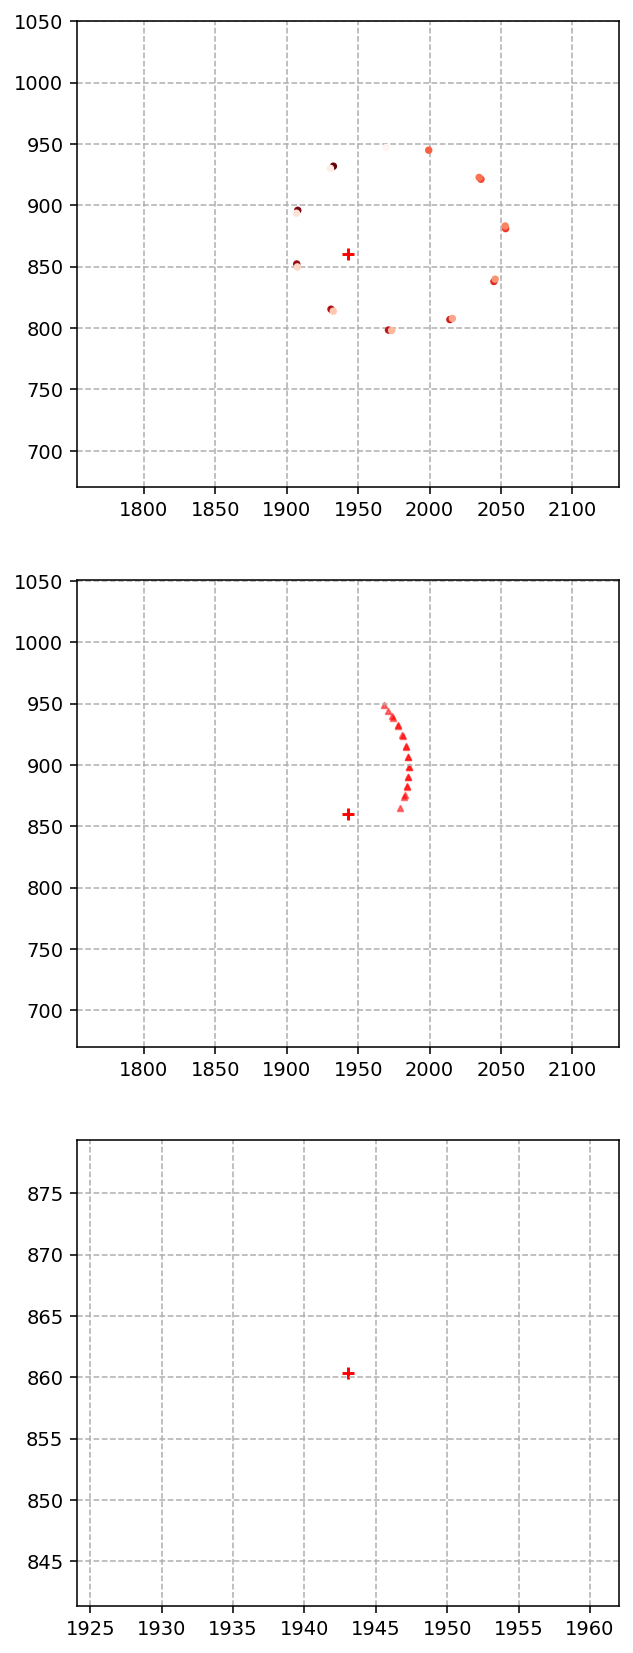

In [206]:
# m2b = query_time(db, datemin='2023-05-25 14:47:00', datemax='2023-05-25 14:48:00')
# m2b = (m2b) & ( db['label'].str.contains('arcph') )
color2='b'
color1=color2

dateStart = np.array(['2023-06-14 19:33:00','2023-06-14 19:41:00','2023-06-14 19:07:00'],dtype='datetime64') # arcth time, arcph time, and arcth30small time
dateEnd = dateStart+np.timedelta64(4,'m')

m1 =  query_time(db, datemin=dateStart[0],datemax=dateEnd[0])
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')
# m1 = (m1) & (db['direction']=='cw')

m2 = query_time(db, datemin=dateStart[1],datemax=dateEnd[1])
m2 = (m2) & ( db['label'].str.contains('arcph') )

m3 = query_time(db, datemin=dateStart[2],datemax=dateEnd[2])
m3 = (m3) & ( db['label'].str.contains('arcth30smallPhi') )

fig,axs = plt.subplots(3,1,figsize=[5,15])

x_center,y_center,offset,small_scalar = xc/pix2mm,yc/pix2mm, 190,0.1

# Plotting


axs[0].scatter('xpix', 'ypix', data=db[m1], c=np.arange(m1.sum()), cmap='Reds_r',  s=8, zorder=10)
axs[0].set_ylim(y_center-offset,y_center+offset)
axs[0].set_xlim(x_center-offset,x_center+offset)
axs[0].scatter(x_center,y_center,marker='+',c='red')
axs[0].grid(ls='--')

axs[1].scatter('xpix', 'ypix', data=db[m2], c='r', marker='^', s=8, alpha=0.5)
axs[1].set_ylim(y_center-offset,y_center+offset)
axs[1].set_xlim(x_center-offset,x_center+offset)
axs[1].scatter(x_center,y_center,marker='+',c='red')
axs[1].grid(ls='--')

axs[2].scatter('xpix', 'ypix', data=db[m3], c=np.arange(m3.sum()), cmap='Reds_r',  s=8, zorder=10)
axs[2].set_ylim(y_center-offset*small_scalar,y_center+offset*small_scalar)
axs[2].set_xlim(x_center-offset*small_scalar,x_center+offset*small_scalar)
axs[2].scatter(x_center, y_center,marker='+',c='red')
axs[2].grid(ls='--')

plt.show()

In [197]:
xc_small, yc_small, Rarc_small= [i*pix2mm for i in fc.get_circle(db[m3],)]
print(f'mm center from small circle: [{xc_small},{yc_small}]')
print(f'Pixel center from small circle: [{xc_small/pix2mm},{yc_small/pix2mm}]')

mm center from small circle: [69.9818905407083,30.903346062054347]
Pixel center from small circle: [1978.7048048086099,873.7774710741797]


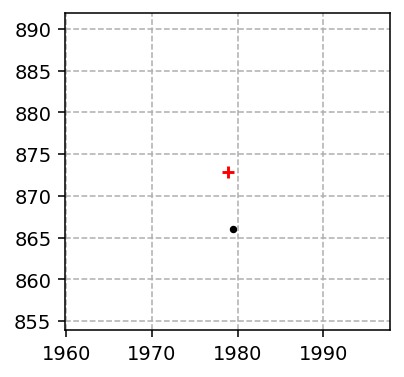

In [198]:
fig,ax = plt.subplots(figsize=[3,3])

plt.scatter('xpix', 'ypix', data=db[m3].iloc[0], c='black',  s=8)
plt.ylim(y_center-offset*small_scalar,y_center+offset*small_scalar)
plt.xlim(x_center-offset*small_scalar,x_center+offset*small_scalar)
plt.scatter(x_center, y_center,marker='+',c='red')
plt.grid(ls='--')
plt.show()

In [199]:
pix2mm = 0.03536752443853155 # PLACEHOLDER!

# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)] # center and radius of theta arc
# print(xc1, yc1, Rarc1)


xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])] # center and radius of phi arc
# print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)

# Capturing important pixels for hardstop angle - I think pix2mm is the incorrect naming convention, it should be millimeters to pixel? so long as we know moving forward - Sean
hardStop = angle_between(np.array([xc,yc]), np.array([xc+5,yc]), (xc2,yc2))

# computing the small offset of the exclusion zone, taken at first point of the hardstop
small_offsets = np.array([db[m3][['xpix','ypix']].reset_index(drop=True).iloc[0]['xpix'],db[m3][['xpix','ypix']].reset_index(drop=True).iloc[0]['ypix']])*pix2mm-np.array([xc,yc])
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1 (mm): {R1:.8} \nR2 (mm): {R2:.8}")
print(f"xc, yc (mm): [{xc:.5f}, {yc:.5f}]")
print(f"Hardstop angle (degrees): {hardStop:.5f}")
print(f"pix2mm {pix2mm}")
print(f"pixcenter [{xc/pix2mm:.5f}, {yc/pix2mm:.5f}]")
print(f"offset of phi arm at home position (mm) [{small_offsets[0]:.5f},{small_offsets[1]:.5f}] ")

R1 (mm): 2.9414621 
R2 (mm): 3.0485513
xc, yc (mm): [69.98678, 30.87172]
Hardstop angle (degrees): 163.18739
pix2mm 0.03536752443853155
pixcenter [1978.84315, 872.88322]
offset of phi arm at home position (mm) [0.02114,-0.24062] 


In [201]:
db[m2]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
2547,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194139,4852,cw,cruise,phi,0.0,1979.324740,865.036129,0,79925.6431,3.4520
2548,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194149,4852,cw,cruise,phi,15.0,1982.832705,875.772573,0,79656.9385,3.4251
2549,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194158,4852,cw,cruise,phi,15.0,1984.278386,882.982295,0,79973.1026,3.4473
2550,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194206,4852,cw,cruise,phi,15.0,1985.160635,889.997688,0,80238.8403,3.4155
2551,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194215,4852,cw,cruise,phi,15.0,1985.403444,898.407163,0,77844.0797,3.4689
2552,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194225,4852,cw,cruise,phi,15.0,1984.871313,906.883729,0,79827.9940,3.4131
2553,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194235,4852,cw,cruise,phi,15.0,1983.585120,914.811036,0,79219.2717,3.4464
2554,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194244,4852,cw,cruise,phi,15.0,1981.005481,924.192647,0,80324.6213,3.4150
2555,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194254,4852,cw,cruise,phi,15.0,1977.632374,932.862742,0,79300.3805,3.4471
2556,arcph15,2023-06-14 19:41:37,0.0,0.0,20230614-194303,4852,cw,cruise,phi,15.0,1973.963773,939.890873,0,80094.2793,3.4253


In [202]:
m2 = query_time(db, datemin='2023-05-25 17:25:00')
m2 = (m2) & ( db['label'].str.contains('arcph') )
color2 = ['b' if i =='cw' else 'r' for i in db['direction'][m2]]

m1 = query_time(db, datemin='2023-05-23 13:18:00')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')
color1 = ['b' if i =='cw' else 'r' for i in db['direction'][m1]]

# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)] # center and radius of theta arc
# print(xc1, yc1, Rarc1)


xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])] # center and radius of phi arc
# print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)

# Capturing important pixels for hardstop angle - I think pix2mm is the incorrect naming convention, it should be millimeters to pixel? so long as we know moving forward - Sean
hardStop = angle_between(np.array([xc,yc]), np.array([xc+5,yc]), (xc2,yc2))
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1 (mm): {R1:.8} \nR2 (mm): {R2:.8}")
print(f"xc, yc (mm): [{xc:.5f}, {yc:.5f}]")
print(f"Hardstop angle (degrees): {hardStop:.5f}")
print(f"pix2mm {pix2mm}")
print(f"pixcenter [{xc/pix2mm:.5f}, {yc/pix2mm:.5f}]")

R1 (mm): 2.5320973 
R2 (mm): 3.0165557
xc, yc (mm): [68.72165, 30.42789]
Hardstop angle (degrees): 128.44557
pix2mm 0.03536752443853155
pixcenter [1943.07218, 860.33430]


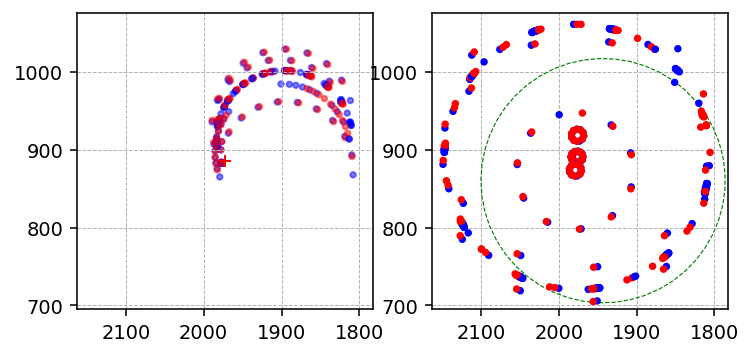

In [203]:
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], c=color2, s=8, alpha=0.5)
setplot(1973, 885, 190)

plt.subplot(122)

plt.scatter('xpix', 'ypix', data=db[m1], c=color1, s=8, zorder=10)
plot_circle(xc/pix2mm, yc/pix2mm, (R1+R2)/pix2mm)
setplot(1973, 885, 190)

In [11]:
db['xmm'] = db["xpix"].values * pix2mm #-xc
db['ymm'] = db["ypix"].values * pix2mm #-yc

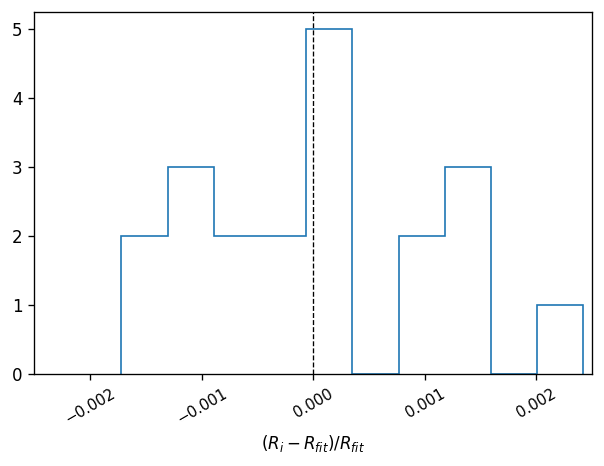

In [12]:
# msk_arcth1 =( db['label'].str.contains('arcth30') )| (db['direction']=='cw') & (query_time(db, "2023-02-07"))
DR = np.hypot(db['xmm'][m1] - xc, db['ymm'][m1] - yc)
DRcw = np.hypot(db['xmm'][m1 & (db.direction=='cw')] - xc, db['ymm'][m1& (db.direction=='cw')] - yc)
DRccw = np.hypot(db['xmm'][m1 & (db.direction=='ccw')] - xc, db['ymm'][m1& (db.direction=='ccw')] - yc)

plt.hist(DR - Rarc1 , histtype='step', density=False)
# plt.hist(DRcw- Rarc1, histtype='step', density=True)
# plt.hist(DRccw -Rarc1, histtype='step', density=True)


plt.xlabel("$ (R_i - R_{fit})/ R_{fit}$")
plt.xticks(fontsize=9, rotation =30); 
plt.xlim(-0.0025, 0.0025)
plt.axvline(0, c='k',lw=0.8, zorder=0, ls='--')

In [13]:
askedangle = db[m2]['angle'].values * np.array( [1 if i =='ccw' else -1 for i in  db[m2]['direction']])

In [14]:
# #CW
# dang=[]
# correction = -2*1.995
# kwplot = dict(marker='o', edgecolors='k', alpha=0.6)
# msk = (m2) & (db['direction'] == 'cw')
# c = ['b' if i == 'cw' else 'r' for i in db[msk]['direction']]

# for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
#     dang.append(angle_between((xc2,yc2), (-6,0), (i, j)))
    
# dang = np.array(dang)[0:]
# displ = dang[1:]-dang[:-1] 
# plt.scatter(range(len(dang)-1), -displ + 0*correction, c='b', #c[1:], 
#          label='', **kwplot)

# plt.scatter(range(len(dang)-1), askedangle[1:] + -correction*np.sign(askedangle[1:]), marker='x', 
#          alpha=0.6)

# CCW
dang=[]
msk = (m2) & (db['direction'] == 'cw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = -np.array(dang)[2:-3]

plt.scatter(range(len(dang)-1), dang[1:]-dang[:-1] + correction, c='b', 
            label='cw', **kwplot)


# CCW
dang=[]
msk = (m2) & (db['direction'] == 'ccw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = np.array(dang)[:-3]

plt.scatter(range(5,len(dang)-1 +5), dang[1:]-dang[:-1] + correction, c='r', 
            label='ccw', **kwplot)


plt.ylim(14.5, 15.5)
plt.xlabel("move id")
plt.ylabel("angle (deg)")
plt.grid('--', lw=.4)
plt.title("phi motor")

plt.axhline(15, c='k', zorder=0, lw=.8, label='requested angle')
plt.legend(loc='best', fontsize=8)

plt.show()
plt.plot(np.cumsum(displ) -1*np.cumsum(displ).min())
csumasked = np.cumsum(askedangle[1:] -correction*np.sign(askedangle[1:])) 
plt.plot(csumasked - csumasked.min()  )
plt.grid()

NameError: name 'correction' is not defined

In [ ]:
db[m2]

# xy test

In [ ]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
pix2mm = 0.03536752443853155
xc, yc = [69.96433, 31.51567]

In [ ]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
get_timecol(db)
plt.scatter('xpos', 'ypos', data=get_lastdbxy(12), marker='x')
# plt.scatter('xpos', 'ypos', data = xytgt, marker='.')
plt.gca().set_aspect('equal')
# plt.pause(1)
# plt.show()

In [ ]:
db['session'][db["label"].str.contains('xy60')].unique()

In [ ]:
label='xy60'
dt1, dt2 = '2023-03-09 18:05:35', '2023-03-09 19:01:38'
dt1, dt2 = '2023-03-09 19:05:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 19:45:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:02:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:20:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 21:10:35', '2023-03-09 21:30:38'
dt1, dt2 = '2023-03-10 10:20:00', '2023-03-10 10:22:00' # backlash = 1.8 best case so far
# dt1, dt2 = '2023-03-10 10:40:00', '2023-03-10 10:42:00' # backlash = 2.0
#dt1, dt2 = '2023-03-10 10:58:00', '2023-03-10 10:59:00' # backlash = 1.9
# dt1, dt2 = '2023-03-10 11:13:00', '2023-03-10 11:14:00' # backlash = 1.8 + sleep 01 s

def get_lastdbxy(tail, label='xy60'):
    mxy = db["label"].str.contains(label)
#     mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    dbxy = db[['xpix','ypix']][mxy].tail(tail).reindex()
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def get_dbxy(db,  datemin, datemax, label='xy60'):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def plot_xy(label, datemin, datemax, movefn="XY_60b.txt", title='', show=True ):
    dbxy = get_dbxy(db, datemin, datemax,label='xy60')
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=20)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    plt.scatter('xpos', 'ypos', data=xytgt, edgecolors='r', s=20, c='', lw=1,label='target')
    plt.xlabel('xpos (mm)')
    plt.ylabel('ypos (mm)')
    plt.title(title, fontsize=8)
    plt.xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_xyhist(label, datemin, datemax, dbxy=None, joinplot=False, plotall=False):
    if dbxy is None:
        dbxy = get_dbxy(db, datemin, datemax)
    dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
    rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
    dr = np.hypot(dx, dy)
    if plotall:
        plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
        plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
        plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
        plt.legend(loc='best', fontsize=9)
        plt.show()
    plt.hist(np.hypot(dx,dy), histtype='step')
    plt.xlabel('$\delta r \;(mm)$')
    if not joinplot:
        plt.show()
    return dr
    
plot_circle(0,0, 6.04)
plt.plot(np.linspace(0, 6.04* np.cos(-166)), np.linspace(0, 6.04* np.sin(-166)), lw=1 , c='g', label='hardstop'  )
plt.grid(lw=0.6, ls='--')   
plt.annotate('$1.0\\vec{g}$', xy=(5.3, -6), xycoords='data',
             xytext=(5.3, -5), textcoords='data',
             horizontalalignment='center',
             fontsize=8,
             arrowprops=dict(color='k', lw=.4, width=.4, headwidth=3.0,
                             headlength=3.0, ls='-')
           )
dbxy, xytgt = plot_xy(label, dt1, dt2, title='posid:4852\n2023-03-10T10:21:45' )

rdiff = plot_xyhist(label, dt1, dt2, dbxy=dbxy)



In [ ]:
dados = [rdiff.min(), rdiff.max(), np.median(rdiff), np.sqrt(np.mean(rdiff**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

In [ ]:
rmsk = rdiff<0.2

dados = [rdiff[rmsk].min(), rdiff[rmsk].max(), np.median(rdiff[rmsk]), np.sqrt(np.mean(rdiff[rmsk]**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

In [ ]:
3*np.radians(1)

In [ ]:
np.degrees(np.arctan( (5.789/1.743)**-1))

In [ ]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx/dr, '.-', label='dx/dr', alpha=0.5)
plt.plot(dy/dr, '.-', label='dy /dr', alpha=0.5)
# plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()


In [ ]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')
plt.xlabel('$\delta r \;(mm)$')

In [ ]:
plt.plot(yt)

In [ ]:
# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))

label = 'xy60'
xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt + 0.0514)
v = 1e3 * (ypos - yt +  0.01185)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=120
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

np.mean(dr)

In [ ]:
def func(xoff, yoff):
    u = 1e3 * (xpos - xt + xoff)
    v = 1e3 * (ypos - yt + yoff)
    return np.sqrt(np.mean(np.hypot(u, v)**2))



xx,yy = np.random.rand(30000)*2*0.1 -0.1, np.random.rand(30000)*2*0.1 - 0.1

vals = np.array([func(ii,  jj) for (ii, jj) in zip(xx,yy)])
amin = np.argmin(vals)
vals.shape, vals[amin], xx[amin], yy[amin]

In [ ]:
plt.scatter(xx,yy, c=vals, cmap='viridis_r', s=.6 )
plt.plot(xx[amin], yy[amin], 'rx')
plt.xlabel("xoff (um)")
plt.ylabel("yoff (um)")
plt.colorbar(label='RMS')

In [ ]:
m2 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m2 = (m2) & ( db['label'].str.contains('arcph') )
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], s=8)
setplot(1973, 885, 190)

plt.subplot(122)

m1 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')

plt.scatter('xpix', 'ypix', data=db[m1], s=8)
setplot(1973, 885, 190)


In [ ]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4}, R2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

In [ ]:
6*np.sin(np.radians(2)), np.radians(2)

# UPDATE THE CODE WITH THE VALUES ABOVE

In [ ]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4} \nR2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

In [ ]:
ddd = np.array([124.27, 143.27, 163.17, 180])
ddd[1:] - ddd[:-1]

In [ ]:
ddd = np.array([3.8867,26.4787, 58.06, 89.65, 59.5557, 27.9447])
ddd[1:] - ddd[:-1], 15*50/33 +2*4.53, (15 + 2*4.53) * 50/33

In [ ]:
(15 - 2)*50/33 + 2*4.53